# 株価予測

In [1]:
# ライブラリインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

# 設定
pd.options.display.max_columns = 100
pd.options.display.max_rows = 50

%matplotlib inline


In [2]:
# データの読み込み
dir_path = "/Users/Tomoki Yako/tech/competition/SIGNATE/stock-prediction/data/"
train_df = pd.read_csv(dir_path + "train.csv", encoding='utf-8')
test_df = pd.read_csv(dir_path + "test.csv", encoding='utf-8')

In [3]:
train_df.head()

,Date,Open,High,Low,Close,Up
0,2004-01-02,50.85,50.91,50.62,50.72,1
1,2004-01-05,50.75,50.84,50.61,50.79,1
2,2004-01-06,50.87,51.26,50.86,51.15,1
3,2004-01-07,51.45,51.54,51.29,51.51,0
4,2004-01-08,51.15,51.33,51.02,51.28,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2026 entries, 0 to 2025
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2026 non-null   object 
 1   Open    2026 non-null   float64
 2   High    2026 non-null   float64
 3   Low     2026 non-null   float64
 4   Close   2026 non-null   float64
 5   Up      2026 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 95.1+ KB


In [5]:
test_df.head()

,Date,Open,High,Low,Close
0,2012-01-19,110.79,110.82,109.96,110.39
1,2012-01-20,110.45,111.10,110.36,110.73
2,2012-01-23,110.95,111.10,109.65,110.36
3,2012-01-24,110.16,110.16,108.13,108.39
4,2012-01-25,106.25,107.11,105.97,106.89


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1200 non-null   object 
 1   Open    1200 non-null   float64
 2   High    1200 non-null   float64
 3   Low     1200 non-null   float64
 4   Close   1200 non-null   float64
dtypes: float64(4), object(1)
memory usage: 47.0+ KB


In [7]:
# 基礎集計
df = pd.concat([train_df, test_df], ignore_index=None)
df.shape

(3226, 6)

In [8]:
# plt.figure(figsize=(6, 4))
# sns.relplot(data=df, x='Date', y='Close', kind='line')
# plt.show()

In [9]:
# plt.figure(figsize=(6, 4))
# sns.countplot(data=train_df, x='Up')
# plt.show()

In [10]:
# # 特徴量エンジニアリング
# # 移動平均 Moving Average (MA)
ma_day = [20]#, 50, 200]
for ma in ma_day:
    column_name = f"{ma}MA"
    df[column_name] = df['Close'].rolling(ma, min_periods=1).mean()

In [11]:
# データの分割
train = df[~df['Up'].isnull()]
test = df[df['Up'].isnull()]
test.head()


,Date,Open,High,Low,Close,Up,20MA
0,2012-01-19,110.79,110.82,109.96,110.39,NaN,109.4080
1,2012-01-20,110.45,111.10,110.36,110.73,NaN,109.5215
2,2012-01-23,110.95,111.10,109.65,110.36,NaN,109.5675
3,2012-01-24,110.16,110.16,108.13,108.39,NaN,109.5720
4,2012-01-25,106.25,107.11,105.97,106.89,NaN,109.4415


In [12]:

X_train = train.drop(columns=['Date', 'Up', 'Close'])
# X_train = train.drop(columns=['Date', 'Up', 'Low', 'High' ])
y_train = train['Close']
print("元のデータフレーム", train.shape)
print("説明変数", X_train.shape)
print("目的変数", y_train.shape)

元のデータフレーム (2026, 7)
説明変数 (2026, 4)
目的変数 (2026,)


In [13]:
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=False, random_state=42)
# X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [14]:
X_tr.head()

,Open,High,Low,20MA
0,50.85,50.91,50.62,50.720000
1,50.75,50.84,50.61,50.755000
2,50.87,51.26,50.86,50.886667
3,51.45,51.54,51.29,51.042500
4,51.15,51.33,51.02,51.090000


In [15]:
y_tr.value_counts()

Close
58.57    5
75.14    5
58.38    5
58.34    4
52.20    4
        ..
64.04    1
64.22    1
64.12    1
63.66    1
85.70    1
Name: count, Length: 1217, dtype: int64

In [16]:
y_va.value_counts()

Close
91.14     3
89.15     3
88.56     2
97.70     2
87.48     2
         ..
91.00     1
91.34     1
91.29     1
91.22     1
110.58    1
Name: count, Length: 364, dtype: int64

In [17]:
X_test = test.drop(columns=['Date', 'Up', 'Close'])
X_test.head()

,Open,High,Low,20MA
0,110.79,110.82,109.96,109.4080
1,110.45,111.10,110.36,109.5215
2,110.95,111.10,109.65,109.5675
3,110.16,110.16,108.13,109.5720
4,106.25,107.11,105.97,109.4415


In [18]:
params = {
            'task':         'train',
            'boosting_type':'gbdt',
            'objective':    'regression',
            'metric':       'rmse',
            'verbose':      '2',
            # 'force_col_wise':'True',
            'random_state': '42'
}

In [19]:
train_data = lgb.Dataset(X_tr, label=y_tr)
eval_data = lgb.Dataset(X_va, label=y_va, reference=train_data)

In [20]:
gbm = lgb.train(params,
                train_data,
                valid_sets=eval_data,
                )

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000022 seconds, init for row-wise cost 0.000532 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 1620, number of used features: 4
[LightGBM] [Info] Start training from score 66.774451
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained 

In [21]:
y_tr_prob_gbm = gbm.predict(X_tr)
# y_tr_pred_gbm = np.where(y_tr_prob_gbm < 0.5, 0, 1)
y_va_prob_gbm = gbm.predict(X_va)
# y_va_pred_gbm = np.where(y_va_prob_gbm < 0.5, 0, 1)

# print(type(y_tr_prob_gbm))
# print(type(y_va_prob_gbm))
array_gbm = np.concatenate([y_tr_prob_gbm, y_va_prob_gbm])
# print(type(array))

# print(y_tr_prob_gbm.shape)
# print(y_va_prob_gbm.shape)
# print(array.shape)

# y_va_pred_gbm[:5]
# accuracy_tr_gbm = accuracy_score(y_tr, y_tr_pred_gbm)
# accuracy_va_gbm = accuracy_score(y_va, y_va_pred_gbm)

# print("学習データの精度", accuracy_tr_gbm)
# print("評価データの精度", accuracy_va_gbm)

# y_test_prob_gbm = gbm.predict(X_test)
# y_test_pred_gbm = np.where(y_test_prob_gbm < 0.5, 0, 1)

# test_df['Up'] = y_test_pred_gbm
# test_df['Up'] = test_df['Up'].astype(int)

# submit_df = test_df[['Date', 'Up']].set_index('Date')
# submit_df.dtypes

# submit_df.to_csv("../data/submission_gbm.csv", header=False)

In [22]:
train_df['Predict_GBM'] = array_gbm
# plt.figure(figsize=(16, 9))
# plt.plot(train_df['Date'], train_df['Close'], label="Close")
# plt.plot(train_df['Date'], train_df['Predict_GBM'], label="LightGBM")
# plt.legend()
# # sns.relplot(data=train_df, x='Date', y='Close', kind='line')
# # sns.relplot(data=train_df, x='Date', y='Predict', kind='line')
# plt.show()


In [23]:
train_df.tail()

,Date,Open,High,Low,Close,Up,Predict_GBM
2021,2012-01-11,108.62,109.00,108.41,108.86,1,86.355708
2022,2012-01-12,109.68,109.90,109.44,109.83,0,86.355708
2023,2012-01-13,109.53,109.72,109.08,109.66,1,86.355708
2024,2012-01-17,109.99,110.47,109.57,109.96,1,86.355708
2025,2012-01-18,110.06,110.82,109.94,110.58,0,86.355708


In [24]:
# lgb.plot_importance(gbm)

In [25]:
dtrain = xgb.DMatrix(X_tr, label=y_tr)


In [26]:
param = {'objective': 'reg:squarederror',
         'seed':        42}#, 'num_class': 2}

In [27]:
# 学習
bst = xgb.train(param, dtrain)#, num_round)

In [28]:
dvalid = xgb.DMatrix(X_va)

y_tr_pred_bst = bst.predict(dtrain)
y_va_pred_bst = bst.predict(dvalid)

# accuracy_tr_bst = accuracy_score(y_tr, y_tr_pred_bst)
# accuracy_va_bst = accuracy_score(y_va, y_va_pred_bst)

# print("学習データの精度", accuracy_tr_bst)
# print("評価データの精度", accuracy_va_bst)

array_bst = np.concatenate([y_tr_pred_bst, y_va_pred_bst])

# dtest = xgb.DMatrix(X_test)
# y_test_prob_bst = bst.predict(dtest)
# print(y_test_pred_bst)


# test_df['Up'] = y_test_pred_bst
# test_df['Up'] = test_df['Up'].astype(int)

# submit_df = test_df[['Date', 'Up']].set_index('Date')
# submit_df.dtypes

# submit_df.to_csv("../data/submission_bst.csv", header=False)

c:\Users\Public\Anaconda\envs\kaggle\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Public\Anaconda\envs\kaggle\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


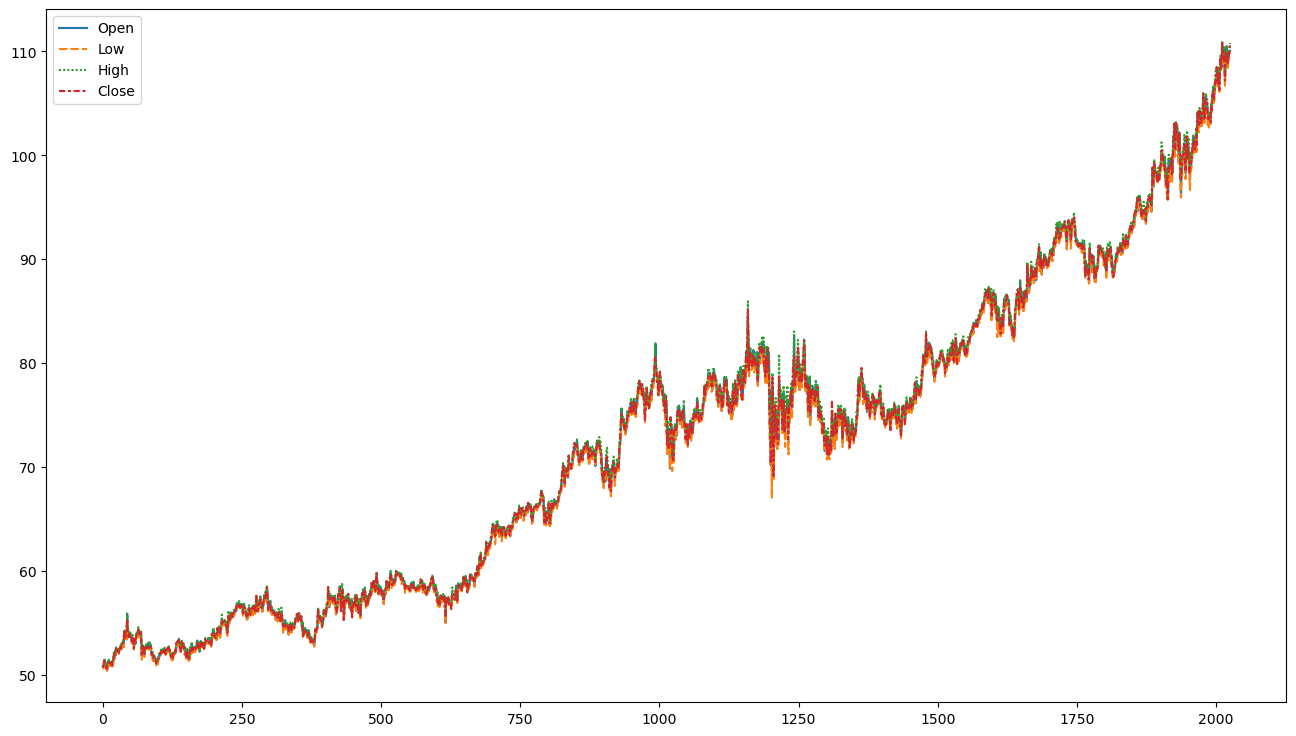

In [29]:
train_df['Predict_XGB'] = array_bst
plt.figure(figsize=(16, 9))
# plt.plot(train_df['Date'], train_df['Close'], label="Close")
# plt.plot(train_df['Date'], train_df['Predict_GBM'], label="LightGBM")
# plt.plot(train_df['Date'], train_df['Predict_XGB'], label="XGBoost")
# plt.legend()
# g = sns.relplot(data=train_df, x='Date', y='Close', kind='line')
# g.map(sns.relplot, data=train_df, x='Date', y='Predict_GBM', kind='line')
sns.lineplot(data=train_df[['Open', 'Low', 'High', 'Close']])
plt.show()


bstは後半全部0になっている

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

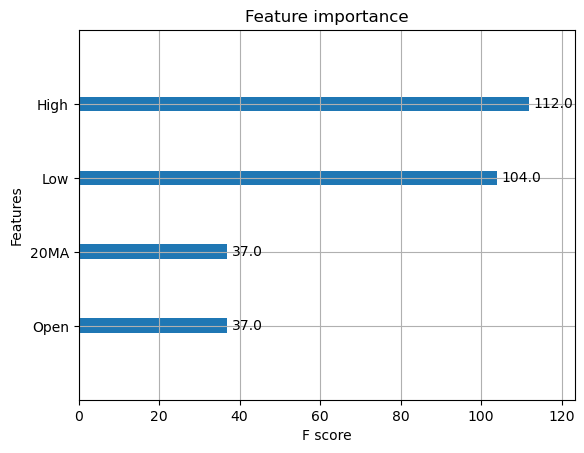

In [30]:
xgb.plot_importance(bst)

# LSTM組んでみる

### まずは普通のNN

In [31]:
nn = MLPRegressor(random_state=42)
nn.fit(X_tr, y_tr)

y_tr_pred_nn = nn.predict(X_tr)
y_va_pred_nn = nn.predict(X_va)

array_nn = np.concatenate([y_tr_pred_nn, y_va_pred_nn])

c:\Users\Public\Anaconda\envs\kaggle\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Public\Anaconda\envs\kaggle\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


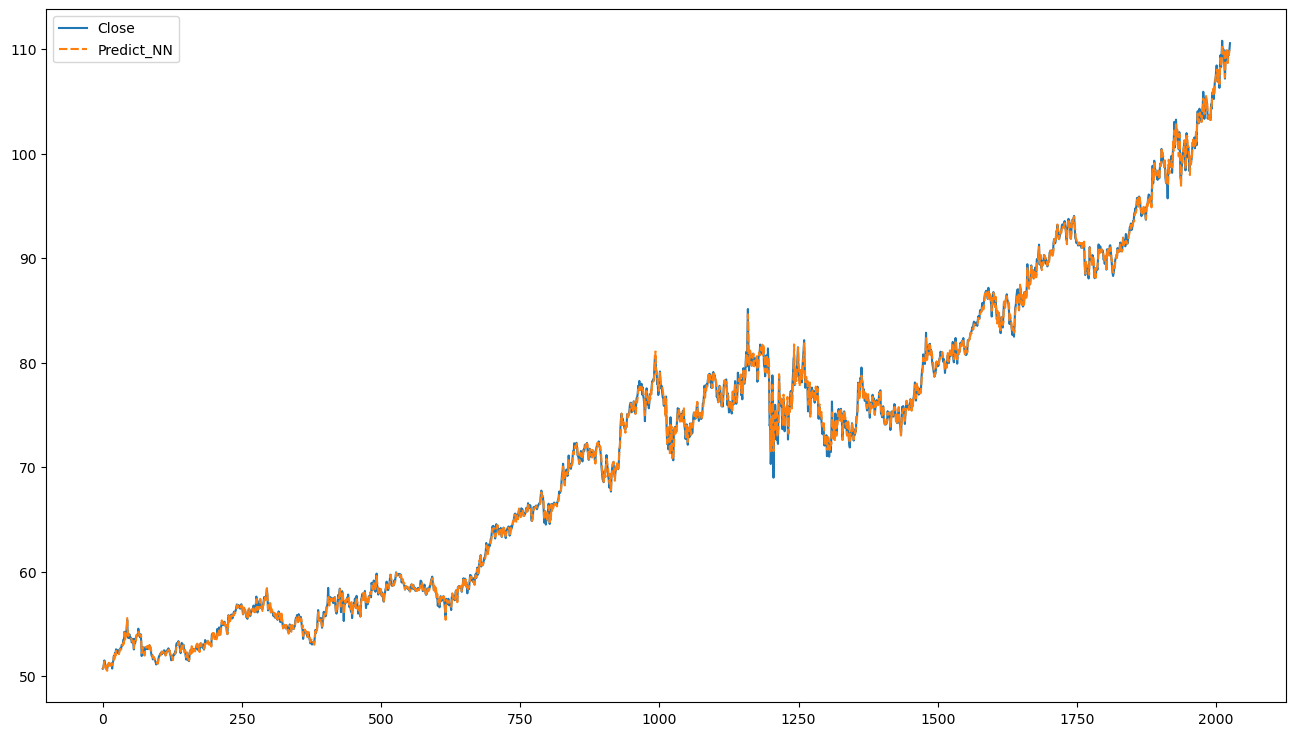

In [32]:
train_df['Predict_NN'] = array_nn
plt.figure(figsize=(16, 9))
sns.lineplot(data=train_df[['Close', 'Predict_NN']])
plt.show()

## LSTM

In [33]:
X_train.shape

(2026, 4)

In [34]:
y_train = np.reshape(y_train, (-1, 1))

In [35]:
y_train.shape

(2026, 1)

In [36]:
# データを0〜1の範囲に正規化
scaler = MinMaxScaler(feature_range=(0,1))
scaled_X_train = scaler.fit_transform(X_train)
scaled_y_train = scaler.fit_transform(y_train)
scaled_X_train

array([[6.99067909e-03, 4.30677489e-03, 3.66788930e-03, 0.00000000e+00],
       [5.32623169e-03, 3.14725857e-03, 3.50116706e-03, 5.98454278e-04],
       [7.32356858e-03, 1.01043565e-02, 7.66922307e-03, 2.84978228e-03],
       ...,
       [9.83688415e-01, 9.78466126e-01, 9.78326109e-01, 9.95562889e-01],
       [9.91344874e-01, 9.90889515e-01, 9.86495498e-01, 9.97298406e-01],
       [9.92509987e-01, 9.96687096e-01, 9.92664221e-01, 1.00000000e+00]])

In [37]:
sc_X_tr, sc_X_va, sc_y_tr, sc_y_va = train_test_split(scaled_X_train, scaled_y_train, test_size=0.2, shuffle=False, random_state=42)

In [38]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(sc_X_tr.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# モデルの視覚化
plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [39]:
# EaelyStoppingの設定
early_stopping =  EarlyStopping(monitor='loss',
                                patience=10)

history = model.fit(sc_X_tr, sc_y_tr,
                    batch_size=32,
                    epochs=100,
                    callbacks=[early_stopping],
                    verbose=1,
                    shuffle=False)

Epoch 1/100
51/51 [==============================] - 17s 30ms/step - loss: 0.0033
Epoch 2/100
51/51 [==============================] - 2s 37ms/step - loss: 0.0567
Epoch 3/100
51/51 [==============================] - 2s 33ms/step - loss: 0.0357
Epoch 4/100
51/51 [==============================] - 2s 35ms/step - loss: 0.0091
Epoch 5/100
51/51 [==============================] - 2s 40ms/step - loss: 0.0024
Epoch 6/100
51/51 [==============================] - 2s 35ms/step - loss: 0.0016
Epoch 7/100
51/51 [==============================] - 2s 39ms/step - loss: 0.0020
Epoch 8/100
51/51 [==============================] - 2s 35ms/step - loss: 0.0019
Epoch 9/100
51/51 [==============================] - 2s 34ms/step - loss: 0.0016
Epoch 10/100
51/51 [==============================] - 2s 41ms/step - loss: 0.0023
Epoch 11/100
51/51 [==============================] - 2s 35ms/step - loss: 0.0029
Epoch 12/100
51/51 [==============================] - 2s 35ms/step - loss: 0.0029
Epoch 13/100
51/51 [====

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 4, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 4, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 4, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 4, 50)             20200     
                                                                 
 dropout_2 (Dropout)         (None, 4, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [41]:
# 予測を実行する
sc_y_tr_pred_LSTM = model.predict(sc_X_tr)
y_tr_pred_LSTM = scaler.inverse_transform(sc_y_tr_pred_LSTM)
sc_y_va_pred_LSTM = model.predict(sc_X_va)
y_va_pred_LSTM = scaler.inverse_transform(sc_y_va_pred_LSTM)

array_LSTM = np.concatenate([y_tr_pred_LSTM, y_va_pred_LSTM])
train_df['Predict_LSTM'] = array_LSTM

# # 二乗平均平方根誤差（RMSE）: 0に近いほど良い
# rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
# print(rmse)

# # 決定係数(r2) : 1に近いほど良い
# r2s = r2_score(y_test, predictions)
# print(r2s)

13/13 [==============================] - 0s 13ms/step


c:\Users\Public\Anaconda\envs\kaggle\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Public\Anaconda\envs\kaggle\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


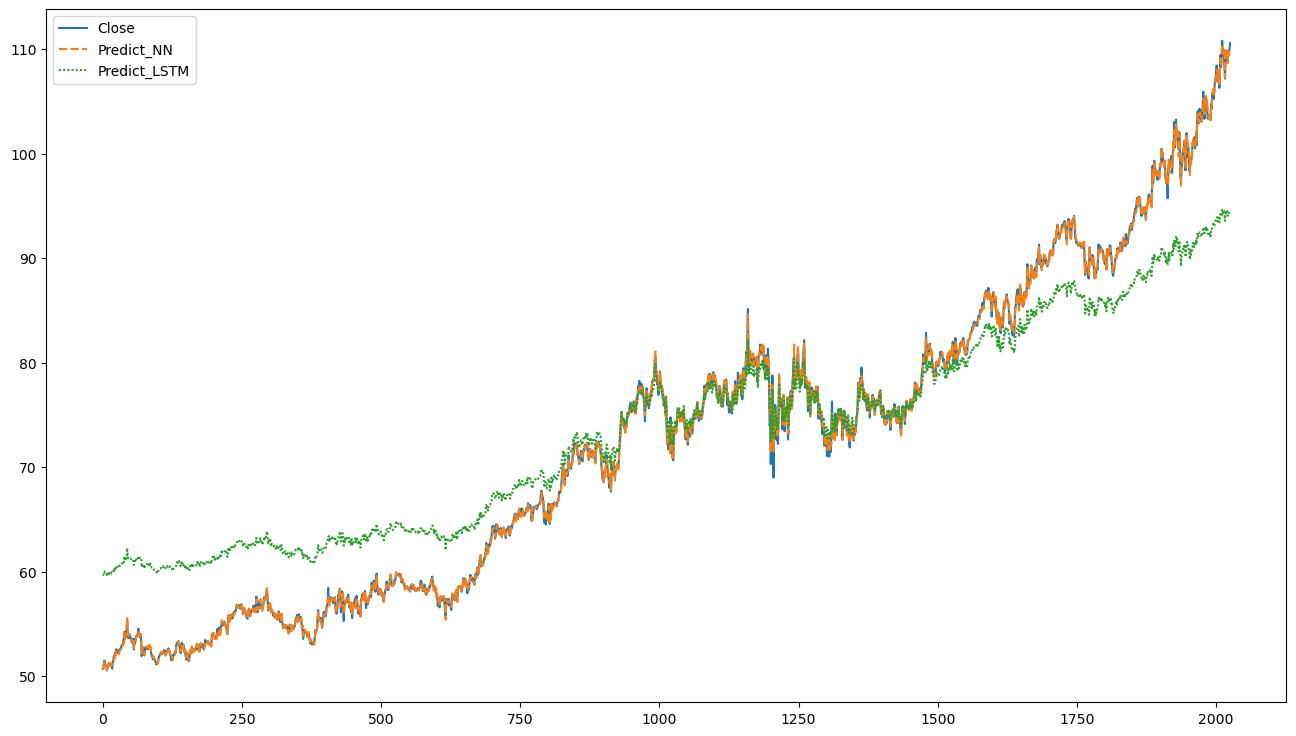

In [42]:
plt.figure(figsize=(16, 9))
sns.lineplot(data=train_df[['Close', 'Predict_NN', 'Predict_LSTM']])
plt.show()